In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import torch
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from Scripts.Configs.ConfigClass import Config
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import networkx as nx
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import random_split, T_co
from torch_geometric.data.lightning import LightningDataset
import pdb
import lightning as L
import time
from Scripts.DataManager.GraphConstructor.CoOccurrenceGraphConstructor import CoOccurrenceGraphConstructor
from Scripts.DataManager.GraphLoader.GLabeledGraphLoader import GLabeledGraphLoader

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')
config = Config(r'C:\Users\fardin\Projects\ColorIntelligence\Scripts\Configs\Config.json')

C:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
train_df = pd.read_csv(r'C:\Users\fardin\Projects\ColorIntelligence\data\Amazon-Review\train_sm.csv')
test_df = pd.read_csv(r'C:\Users\fardin\Projects\ColorIntelligence\data\Amazon-Review\test_sm.csv')
train_df.columns = ['Polarity', 'Title', 'Review']
test_df.columns = ['Polarity', 'Title', 'Review']
train_df = train_df[['Polarity', 'Review']]
test_df = test_df[['Polarity', 'Review']]

In [3]:
config = Config(r'C:\Users\fardin\Projects\ColorIntelligence\Scripts\Configs\Config.json')

execution time in second: 0.001001596450805664


AttributeError: 'CoOccurrenceGraphConstructor' object has no attribute 'unique_words'

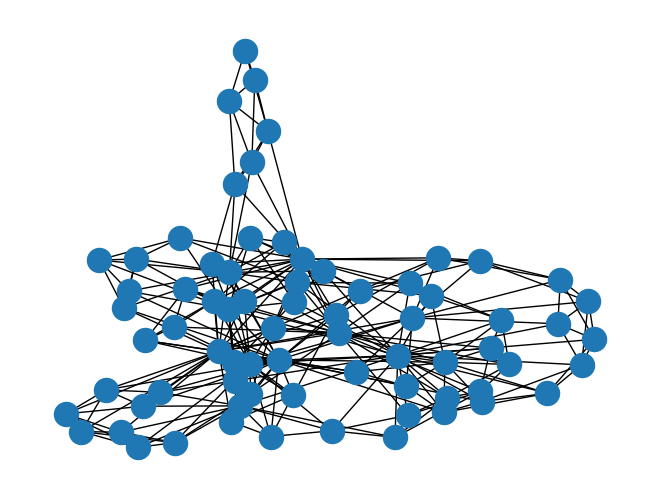

In [12]:
start_time = time.time()
graph_const = CoOccurrenceGraphConstructor(train_df['Review'], 'AmazonReview', config, lazy_construction=True,  load_preprocessed_data=True, naming_prepend='graph')
print(f'execution time in second: {time.time() - start_time}')
# graph_const = CoOccurrenceGraphConstructor(train_df['Review'][:10], 'AmazonReview', config, lazy_construction=False, naming_prepend='graph', load_preprocessed_data=False)
# graph = graph_const.to_graph(train_df['Review'][0])
# graph_const.draw_graph(0)

In [13]:
graph_loader = GLabeledGraphLoader(graph_const, torch.tensor(test_df['Polarity'][:10]),3, 'cpu')

In [145]:
from typing import Any

import torch
import torch.nn.functional as F
from pytorch_lightning.utilities.types import OptimizerLRScheduler, STEP_OUTPUT

from torch_geometric.nn import summary
from tqdm import tqdm

from Scripts.Models.ModelsManager.ModelManager import ModelManager
from Scripts.Models.ClassifierModels.GATGCNClassifierSimple import GNNClassifier
from Scripts.DataManager.GraphLoader.NLabeledGraphLoader import NLabeledGraphLoader
from Scripts.Utils.enums import Optimizer, LossType

import lightning as L


from torch_geometric.nn import GATv2Conv, GCNConv, GCN2Conv
from torch_geometric.nn.dense.diff_pool import dense_diff_pool
from torch_geometric.nn import Sequential as GSequential
from torch import nn
from torch_geometric.nn.dense.diff_pool import dense_diff_pool
from torch_geometric.nn import GATv2Conv, GCNConv, GCNConv
from torch_geometric.data import batch
from torch_geometric.utils import to_dense_adj

In [209]:

from torch.nn import Linear


class GraphAutoEncoderModel(nn.Module):

    def __init__(self, input_feature: int, out_features: int, dropout=0.1, *args, **kwargs):
        super(GraphAutoEncoderModel, self).__init__(*args, **kwargs)
        self.input_features = input_feature
        self.num_out_features = out_features
        self.encoder = GSequential('x, edge_index, edge_weights', [
            (GCNConv(input_feature, 256), 'x, edge_index, edge_weights ->x1'),
            (nn.ReLU(), 'x1->x1'),
            (GCNConv(256, 128), 'x1, edge_index, edge_weights -> x2'),
            (nn.ReLU(), 'x2->x2'),
            (GCNConv(128, 64), 'x2, edge_index, edge_weights -> x3'),
            (nn.ReLU(), 'x3->x3'),
            (GCNConv(64, 32), 'x3, edge_index, edge_weights -> x3'),
            (nn.ReLU(), 'x3->x3'),
            (GATv2Conv(32, 32, 4, dropout=dropout), 'x3, edge_index ->x3'),
            # (GATv2Conv(128, 64, 2, dropout=dropout), 'x2, edge_index->x2'),
            (nn.ReLU(), 'x3->x3'),
            (GCN2Conv(128, 0.5, 0.1, 2), 'x3, x2, edge_index, edge_weights->x3'),
            (nn.ReLU(), 'x3->x3'),
            (GCNConv(128, 256), 'x3, edge_index->x3'),
            (nn.ReLU(), 'x3->x3'),
            (GCN2Conv(256, 0.5, 0.1, 2), 'x3, x1, edge_index, edge_weights->x3'),
            (nn.ReLU(), 'x3->x3')
        ])

        self.pooling_layer1 = GCNConv(256, 5)
        self.pooling_layer2 = GCNConv(256, 1)

        # self.output_layer = GCNConv(256, self.num_out_features)
        self.output_layer = Linear(256, self.num_out_features)

        for module in self.children():
            print(module.named_modules())

    def forward(self, data_batch):
        x1 = self.encoder(data_batch.x, data_batch.edge_index, data_batch.edge_attr)
        x2 = [x1[0 if i==0 else data_batch[i-1].x.shape[0]:data_batch[i].x.shape[0]]
              for i in range(len(data_batch))]
        x3 = torch.zeros((len(x2), 256), dtype = x1.dtype, device = x1.device)
        for i in range(len(x2)):
            s = self.pooling_layer1(x2[i], data_batch[i].edge_index, data_batch[i].edge_attr)
            # adj = to_dense_adj(edge_index=data_batch[i].edge_index, edge_attr=data_batch[i].edge_attr)
            adj = torch.sparse_coo_tensor(data_batch[i].edge_index, data_batch[i].edge_attr).to_dense()
            nodes, adj, _, _ = dense_diff_pool(x2[i], adj, s=s)
            # adj2 = torch.squeeze(adj).to_sparse_coo()
            # x3[i] = Data(x=torch.squeeze(nodes), edge_index=adj2.indices(), edge_attr=adj2.values(), device = x1.device, requires_grad=True)
            s = self.pooling_layer2(x3[i].x, x3[i].edge_index, x3[i].edge_attr)
            nodes, _, _, _ = dense_diff_pool(nodes, adj, s=s)
            x3[i] = torch.squeeze(nodes)

            print(f'nodes: {nodes}')
            print(f'nodes.shape: {nodes.shape}')

        return self.output_layer(x3)

In [210]:
class LightningModel(L.LightningModule):

    def __init__(self, model, optimizer, loss_func):
        super(LightningModel, self).__init__()
        self.optimizer = optimizer
        self.model = model
        self.loss_func = loss_func

    def forward(self, data_batch, *args, **kwargs):
        return self.model(data_batch)

    def training_step(self, data_batch, *args, **kwargs) :
        data, labels = data_batch
        pred_labels = self(data)
        loss = self.loss_func(pred_labels, labels)
        self.log('training_loss', loss)
        return loss

    def validation_step(self, data_batch, *args, **kwargs):
        data, labels = data_batch
        pred_labels = self(data)
        loss = self.loss_func(pred_labels, labels)
        self.log('val_loss', loss)

    # def test_step(self, data_batch, *args: Any, **kwargs: Any) -> STEP_OUTPUT:
    #     data, labels = data_batch
    #     pred_labels = self(data)
    #     loss = self.loss_func(pred_labels, labels)
    #     self.log('test_loss', loss)

    def predict_step(self, data_batch, *args: Any, **kwargs: Any) -> Any:
        data, labels = data_batch
        return self(data)

    def configure_optimizers(self) -> OptimizerLRScheduler:
        return self.optimizer

In [ ]:
train_data = graph_loader.get_train_data()
X, y = next(iter(train_data))

In [214]:
autoencoder_model = GraphAutoEncoderModel(300, 1)
autoencoder_model(X)

<generator object Module.named_modules at 0x00000195F7104890>
<generator object Module.named_modules at 0x00000195F7104890>
<generator object Module.named_modules at 0x00000195F7104890>
<generator object Module.named_modules at 0x00000195F7104890>


AttributeError: 'Tensor' object has no attribute 'x'

In [212]:
autoencoder_model = GraphAutoEncoderModel(300, 1)
lightning_model = LightningModel(autoencoder_model,
                                 torch.optim.Adam(autoencoder_model.parameters(), lr=0.001, weight_decay=0.005), F.cross_entropy)

<generator object Module.named_modules at 0x00000195F6EF50E0>
<generator object Module.named_modules at 0x00000195F6EF50E0>
<generator object Module.named_modules at 0x00000195F6EF50E0>
<generator object Module.named_modules at 0x00000195F6EF50E0>


In [213]:
trainer = L.Trainer(max_epochs=10, accelerator='cpu', devices=1)
trainer.fit(lightning_model, graph_loader.get_train_data(), graph_loader.get_val_data())

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type                  | Params
------------------------------------------------
0 | model | GraphAutoEncoderModel | 245 K 
------------------------------------------------
245 K     Trainable params
0         Non-trainable params
245 K     Total params
0.983     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

AttributeError: 'Tensor' object has no attribute 'x'

In [29]:
train_data = graph_loader.get_train_data()

In [54]:
X, y = next(iter(train_data))
module_0 = GCNConv(300, 256)
output = module_0(X.x, X.edge_index, X.edge_attr)

In [57]:
output2 = [output[:X[0].x.shape[0]], output[X[0].x.shape[0]:X[1].x.shape[0]], output[X[1].x.shape[0]:X[2].x.shape[0]]]

In [143]:
print(type(X[0]))

<class 'torch_geometric.data.data.Data'>


In [178]:
output

tensor([[ 1.2478,  6.8356, -2.8176,  ..., -2.0019, -6.6896, -3.7174],
        [-0.6417, -0.1615, -1.2152,  ...,  1.9769, -2.0857, -1.8125],
        [-1.9308, -0.3655, -2.0221,  ...,  0.6216, -6.3174, -2.8666],
        ...,
        [ 3.0263,  2.5780,  0.3896,  ..., -1.1706, -3.9594, -1.8133],
        [-0.0222, -2.9307, -0.7137,  ...,  0.1376, -0.8414, -1.5121],
        [-2.5861,  0.8166, -0.9879,  ...,  0.4456, -6.1481, -0.9021]],
       grad_fn=<AddBackward0>)

In [177]:
X[0]

Data(x=[72, 300], edge_index=[2, 558], edge_attr=[558])

In [140]:
import torch_geometric

In [142]:
print(X is torch_geometric.data.batch.Batch)

False


In [70]:
gcn_conv = GCNConv(256, 64)

In [144]:
X?

In [95]:
s = gcn_conv(output2[0], X[0].edge_index)
adj = torch.sparse_coo_tensor(X[0].edge_index, X[0].edge_attr).to_dense()
output3 = dense_diff_pool(output2[0], adj, s=s)

In [109]:
output2[0].shape

torch.Size([72, 256])

In [113]:
output3[0].shape

torch.Size([1, 64, 256])

In [112]:
output3[3].shape

torch.Size([])

In [73]:
output.shape

torch.Size([216, 256])

In [74]:
s.shape

torch.Size([216, 64])